# Setup and test algebraic eqn solver

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import os
from scipy.interpolate import interp1d
from scipy import constants

import matplotlib.pyplot as plt
os.chdir(sys.path[0] + '\..') # change our working directory to the root of the pybamm folder
import pybamm
print(pybamm.__path__[0])
%matplotlib widget

c:\Users\Vivian\Dropbox (University of Michigan)\from_box\Research\PyBaMM\PyBaMM\pybamm


In [2]:
class Submodel1(pybamm.BaseSubModel):
    def __init__(self, param, domain, options=None):
        super().__init__(param, domain, options=options)

    def get_fundamental_variables(self):
        u = pybamm.Variable("u")
        v = pybamm.Variable("v")
        return {"u":u, "v": v}

    def get_coupled_variables(self, variables):
        v = variables["v"]
        u = variables["u"]
        variables.update({
            "uv": u*v
        })
        return variables

    def set_rhs(self, variables):
        u = variables["u"]
        self.rhs = {u: 2}

    def set_initial_conditions(self, variables):
        u = variables["u"]
        v = variables["v"]
        self.initial_conditions = { u:1, v: 1}
        
    def set_algebraic(self, variables):
        v = variables["v"]
        u = variables["u"]
        uv = variables["uv"]
        self.algebraic = {v: uv - 10} 

interactive(children=(FloatSlider(value=0.0, description='t', max=1.0, step=0.01), Output()), _dom_classes=('w…

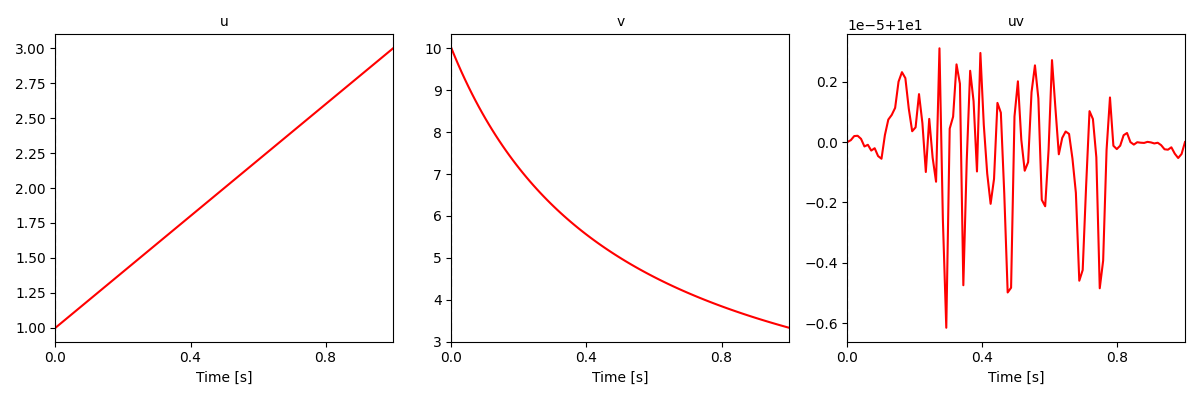

In [4]:
model = pybamm.BaseModel()
model.submodels = {"Particle": Submodel1(None, "Negative")}
model.build_model()

solver = pybamm.CasadiSolver()
sim = pybamm.Simulation(
        model,
        solver=solver,
)
sim.solve([0,1])  
sim.plot(['u','v','uv'])

In [4]:
class PouchVenting(pybamm.BaseSubModel):
    def __init__(self, param):
        super().__init__(param)

    def get_fundamental_variables(self):
        param = self.param
        delta_sigma = pybamm.Variable("Cell expansion stress [kPa]")
        # T_vol_av = pybamm.standard_variables.T_vol_av
        T_vol_av = pybamm.Variable("Volume-averaged cell temperature")

        # T_x_av = pybamm.PrimaryBroadcast(T_vol_av, ["current collector"])
        # T_n = pybamm.PrimaryBroadcast(T_x_av, "negative electrode")
        # u = pybamm.Variable("u")
        v = pybamm.Variable("v")
        variables = {
            "Cell expansion stress [kPa]": delta_sigma,
            "Volume-averaged cell temperature": T_vol_av,
            "Volume-averaged cell temperature [K]": 1 * T_vol_av + 298,
            # 'v':v,
        }
        return variables

    def get_coupled_variables(self, variables):
        param = self.param
        M_C6 = 72/1000
        V_head_0 = 6.65e-6
        L = 2.4/1000
        E = 0.19e3; #kPa
        alpha_cell = 1.1e-6
        P_atm = 101
        P_crit = 158.7731
        R = 8.3145
        A_surf = 0.009
        y_dmc = 0.7
        y_ec = 1-y_dmc        
        m_an = 0.0191
        x_sei_0 = 0.15
        T_amb = 273.15+25
        sigma_0 = 1.5120e+01
        T = variables['Volume-averaged cell temperature [K]'] 
        delta_sigma = variables["Cell expansion stress [kPa]"]

        delta_d = L/E*delta_sigma
        V_head = V_head_0 + A_surf*(delta_d-alpha_cell*T + T_amb)
        delta_T = variables['Volume-averaged cell temperature'] 
        P_dmc = 10**(6.4338-1413.0/(T-44.25))*0.7
        P_ec = 10**(6.4897-1836.57/(T-102.23))*0.3
        P_sat = P_ec + P_dmc         
        n_CO2 = m_an*(x_sei_0 - x_sei_0)/(2*M_C6)
        P_CO2 = (n_CO2*constants.R*T/V_head/1000)/P_crit #kPa
        P_total = P_CO2 + P_sat 
        Q_ohm = pybamm.Scalar(10)
        delta_sigma_gas = P_total-sigma_0-P_atm
        delta_sigma_themal_expansion = E*alpha_cell*delta_T/L
        
        variables.update({
            "uv": delta_sigma*T,
            "Volume-averaged total heating": Q_ohm,
            "Electrolyte gas saturation pressure": P_sat/P_crit,
            "CO2 gas pressure": P_CO2/P_crit,
            "Total gas pressure": P_total/P_crit,
            "Electrolyte gas saturation pressure [kPa]": P_sat,
            "CO2 gas pressure [kPa]": P_CO2,
            "Total gas pressure [kPa]": P_total,
            "Headspace volume [m3]": V_head,
        })
        return variables

    def set_rhs(self, variables):
        param = self.param
        T_vol_av = variables['Volume-averaged cell temperature']
        Q_vol_av = variables["Volume-averaged total heating"]
        T_amb = param.T_amb(pybamm.t * param.timescale)
        cell_surface_area = param.a_cooling
        cell_volume =  param.v_cell
        total_cooling_coefficient = (
            - param.h_total
            * cell_surface_area
            / cell_volume
            / (param.delta ** 2)
                )
        self.rhs = {
            T_vol_av: Q_vol_av/50 + T_vol_av/50,
            }

    def set_initial_conditions(self, variables):
        T = variables['Volume-averaged cell temperature']
        delta_sigma = variables["Cell expansion stress [kPa]"]
        # T = variables['Volume-averaged cell temperature [K]']

        self.initial_conditions = { 
            T:1, 
            delta_sigma: 0, 
            }
        
    def set_algebraic(self, variables):
        L = 2.4/1000
        E = 0.19e3; #kPa
        alpha_cell = 1.1e-6
        P_atm = 101
        sigma_0 = 1.5120e+01
        delta_sigma = variables["Cell expansion stress [kPa]"]
        delta_T = variables['Volume-averaged cell temperature']
        P_total = variables["Total gas pressure [kPa]"]        
        self.algebraic = {
            delta_sigma: delta_sigma - pybamm.maximum(P_total-sigma_0-P_atm, E*alpha_cell*delta_T/L)

            } 


interactive(children=(FloatSlider(value=0.0, description='t', max=120.0, step=1.2), Output()), _dom_classes=('…

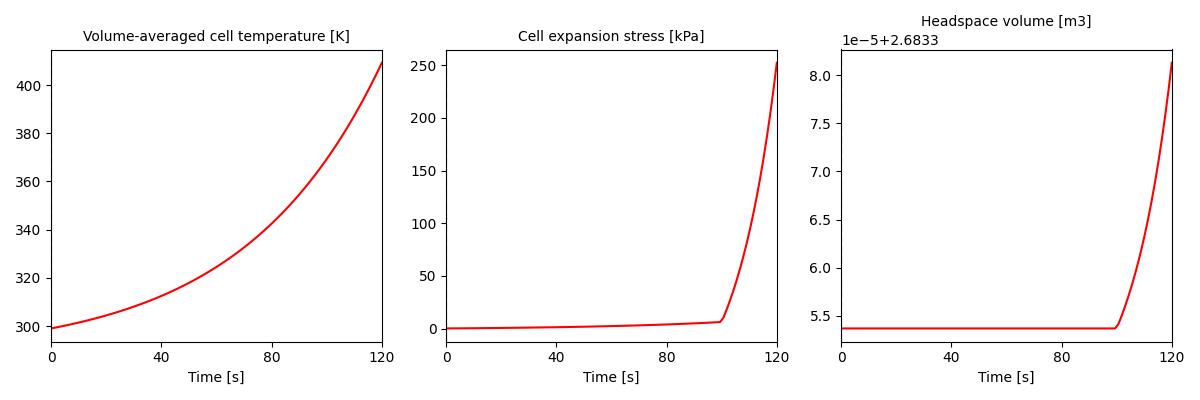

In [5]:
chemistry = pybamm.parameter_sets.Tran2023
parameters = pybamm.ParameterValues(chemistry = chemistry)
param = pybamm.LithiumIonParameters()
model = pybamm.BaseModel()
model.submodels = {"Particle": PouchVenting(param)}
model.build_model()

solver = pybamm.CasadiSolver()
sim = pybamm.Simulation(
        model,
        solver=solver,
)
solution = sim.solve([0,120]) 
sim.plot(["Volume-averaged cell temperature [K]", "Cell expansion stress [kPa]","Headspace volume [m3]"])